# TASK 1
#### forecast = [3.534712 ,3.508492 ,3.572649 ,3.510652 ,3.569082 ,3.528396 ,3.535236]


I haven't used brute force gridsearch or pmdarima as I believe that would defeat the purpose of the exercise
From experience, when determining the parameters via PACF/ACF its worth to check out parameters around the obvious ones. For example if the acf suggest MA = 1 it's worth to check how model behaves on 0 na 2 as well. I didn't go for that approach here too as it falls into 'guessing' category.

To evaluate quality of fit I didn't use metrics like AIC as I wasn't concern with complexity of the model. MSE was chosen as simple way to evaluate plus it allowed to account for cases when model didn't fit correctly on substential spikes (or produced big spike when there was't one.


There is uils clas ForecstMaker in help_utils module (sorry not the most clean code) and the source code with the approaches attended are below

Best approach is marked with (BEST)

In [1]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import warnings
import joblib
from datetime import datetime
from help_utils import ForecastMaker
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#initiate the class and get the data for task one (station 6184 to station 6015)
fm = ForecastMaker()
df= fm.get_data_ex_one()

Data is not stationary, p value is 0.13515174610979036
None


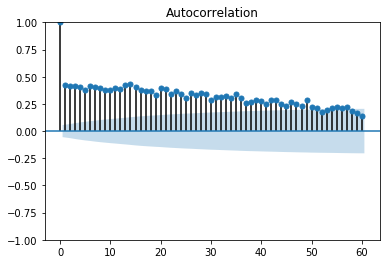

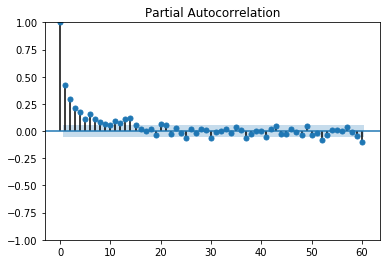

In [3]:
#no seasonality obvious seasonality  
# adfuller's returned p value suggests data is not stationary
plot_acf(df["n_rides"],lags=60);
plot_pacf(df,lags=60);
print (fm.is_stationary(df["n_rides"]))

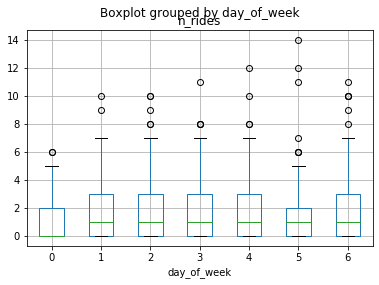

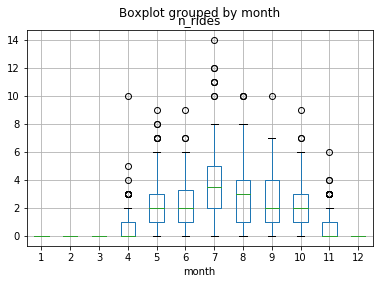

In [4]:
#check for assumtion that there is weekly seasonality. seems to be very weak effect
df["day_of_week"] = df.index.dayofweek
df.boxplot(column='n_rides',by='day_of_week')
del df["day_of_week"]

#check for assumtion that there is yerly seasonality. seems like strong effect
df["month"] = df.index.month
df.boxplot(column='n_rides',by='month')
del df["month"]

In [5]:
# make differencing, now data is statinoary
df["n_rides"] = df["n_rides"].diff()
df.dropna(inplace=True)
fm.is_stationary(df["n_rides"])

Data is stationary, p value is 6.09817862356498e-23


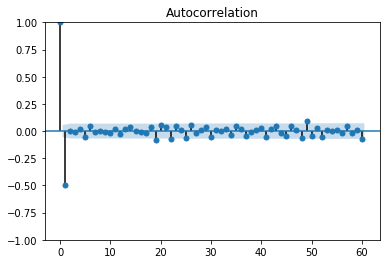

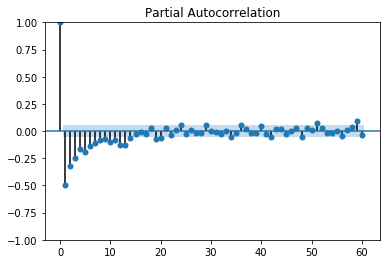

In [6]:
#checjing for lags' acf and pacf significance
#on pacf there is a bigger drop after 1 lag so probably better option but we can afford to check all the option
# d = 1, since we differenced once only
# p = 15 , q = 1 
plot_acf(df["n_rides"],lags=60);
plot_pacf(df,lags=60);

### Approach one
Use all combinations of the parameters picked to fit ARIMA and return one that shown best result on MSE versus test 

3
([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [1], [1])
(1, 1, 1) 6.787519501766687
(5, 1, 1) 6.620637870243832
(6, 1, 1) 6.574563827924699


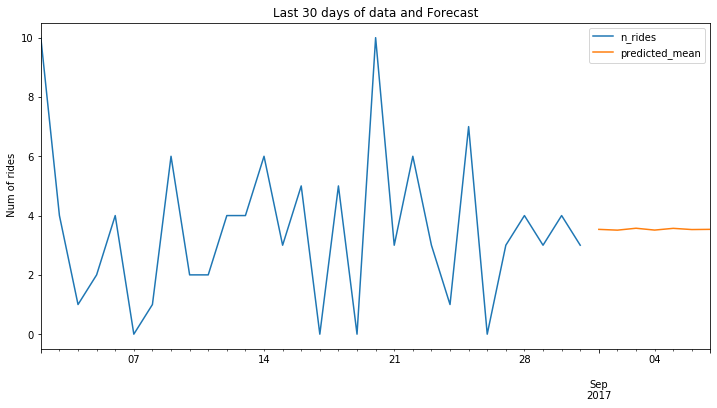

In [3]:
#all possible parameters
# output - forecast of each model that is better than previous one
p = [i for i in range(1,16)]
d = [1]
q = [1]
df= fm.get_data_ex_one()
best_rusults = fm.evaluate_and_return_best_forecast(ARIMA, df,(p,d,q),1)
fm.plot_forecast(df,best_rusults)

In [4]:
best_rusults

{'best_model': <statsmodels.tsa.arima.model.ARIMA at 0x1fcc8020e88>,
 'best_mse': 6.574563827924699,
 'best_forecast': 2017-09-01    3.534712
 2017-09-02    3.508492
 2017-09-03    3.572649
 2017-09-04    3.510652
 2017-09-05    3.569082
 2017-09-06    3.528396
 2017-09-07    3.535236
 Name: predicted_mean, dtype: float64}

### Approach two

Since we know that there is a yearly seasonality but using m=365 is not feasible I trimmed data to only August and September. Now we can try to capture yearly seasonality with m=61 (computing power should be able to mamange this). Plus since we are only interested in forecasting into begining of September focusing on these two months and removing months with empty data may help to capture the patterns better 

Use all combinations of the parameters picked to fit SARIMA and return one that shown best result on MSE versus test 

7
([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1], [1], [0, 1], [0, 1], [0, 1], [7, 61])
i ((1, 1, 1), (0, 0, 0, 7))
((1, 1, 1), (0, 0, 0, 7)) 7.49853027351029
i ((1, 1, 1), (0, 0, 0, 61))
i ((1, 1, 1), (0, 0, 1, 7))
i ((1, 1, 1), (0, 0, 1, 61))
((1, 1, 1), (0, 0, 1, 61)) 7.445788202282429
i ((1, 1, 1), (0, 1, 0, 7))
i ((1, 1, 1), (0, 1, 0, 61))
i ((1, 1, 1), (0, 1, 1, 7))
((1, 1, 1), (0, 1, 1, 7)) 7.165709373687103
i ((1, 1, 1), (0, 1, 1, 61))
i ((1, 1, 1), (1, 0, 0, 7))
i ((1, 1, 1), (1, 0, 0, 61))
i ((1, 1, 1), (1, 0, 1, 7))
i ((1, 1, 1), (1, 0, 1, 61))
i ((1, 1, 1), (1, 1, 0, 7))
i ((1, 1, 1), (1, 1, 0, 61))
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 1), (1, 1, 1, 61))
i ((2, 1, 1), (0, 0, 0, 7))
i ((2, 1, 1), (0, 0, 0, 61))
i ((2, 1, 1), (0, 0, 1, 7))
i ((2, 1, 1), (0, 0, 1, 61))
i ((2, 1, 1), (0, 1, 0, 7))
i ((2, 1, 1), (0, 1, 0, 61))
i ((2, 1, 1), (0, 1, 1, 7))
((2, 1, 1), (0, 1, 1, 7)) 7.146121515938673
i ((2, 1, 1), (0, 1, 1, 61))
i ((2, 1, 1), (1, 0, 0, 7))
i ((2, 1, 1), (1, 0, 0, 61))
i ((

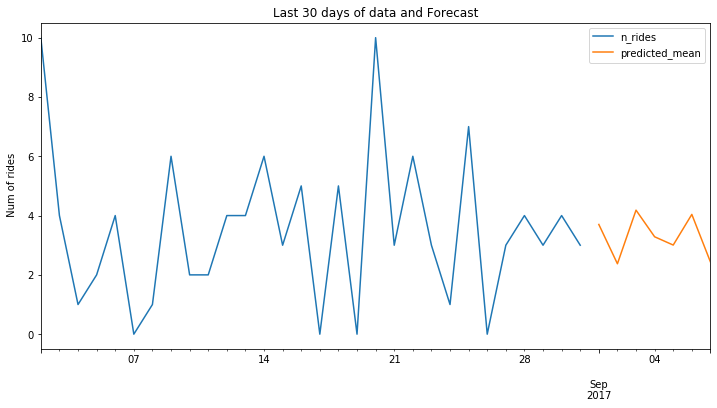

In [8]:
p = [i for i in range(1,11)] # reduced p to 10 previous experiments shown that nothing good happens after 10
d = [1]
q = [1]
P = [0,1]
D = [0,1]
Q = [0,1]
m = [7,61] # will try 7 as there is some seasonality even if weak one
df= fm.get_data_ex_one(True)
best_rusults_speccial = fm.evaluate_and_return_best_forecast(SARIMAX, df, (p,d,q,P,D,Q,m), 1)
fm.plot_forecast(df,best_rusults_speccial)